### Preparation of "adata" for LLM annotation of Leiden clusters preprocessing by configuring the project pipeline parameters.

In [ ]:
# --------------------------------------------------
# Integrated Spatial Transcriptomics + Leiden Clustering (Leiden-optimized CellPie)
# Gene graph vs Combined (gene+image) graph + CellPie (intNMF) optimized by ARI over resolutions
# --------------------------------------------------

# 0) Imports & setup
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc, squidpy as sq
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from matplotlib.colors import to_hex


# ---- paths
visium_path = "C:/Users/abuhu/cellpie/cellpie/knee_spatial_python/knee"  
output_dir = "results_Python/figures"
os.makedirs(output_dir, exist_ok=True)

# ---------- Leiden safety helpers ----------
def _needs_pca(adata, n_pcs):
    """Return True if PCA is missing/invalid or has fewer than n_pcs components."""
    if "X_pca" not in adata.obsm or adata.obsm["X_pca"] is None:
        return True
    Xp = adata.obsm["X_pca"]
    return (Xp.shape[0] != adata.n_obs) or (Xp.shape[1] < n_pcs)

def _neighbors_params(adata):
    """Safely read current neighbor params (if any)."""
    try:
        return dict(adata.uns.get("neighbors", {}).get("params", {}))
    except Exception:
        return {}

def ensure_pca_and_default_neighbors(adata, *, n_neighbors=10, n_pcs=40, min_pcs_compute=50):
    """
    Ensures PCA (>= n_pcs) exists in adata.obsm['X_pca'] and that the *default*
    neighbors graph matches (n_neighbors, n_pcs) for Leiden clustering.
    Recomputes only when necessary.
    """
    # 1) PCA: compute/recompute only if missing/too small/invalid
    if _needs_pca(adata, n_pcs):
        sc.tl.pca(adata, n_comps=max(n_pcs, min_pcs_compute), svd_solver="arpack")
    # tidy dtype (saves RAM and avoids float64/32 mismatches later)
    adata.obsm["X_pca"] = adata.obsm["X_pca"].astype(np.float32, copy=False)

    # 2) Neighbors (default gene graph; no key_added) — rebuild only if params differ
    p = _neighbors_params(adata)
    need_neighbors = (
        ("neighbors" not in adata.uns) or
        (p.get("n_neighbors") != n_neighbors) or
        (p.get("n_pcs") != n_pcs) or
        (p.get("use_rep", None) is not None)  # if an alternate rep was used before
    )
    if need_neighbors:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)  # default neighbors (gene graph)

# --------------------------------------------------
# 1) Load Visium data + Expert annotations
# --------------------------------------------------
adata = sq.read.visium(path=visium_path, load_images=True)
adata.var_names_make_unique()
adata.obsm["spatial"] = np.array(adata.obsm["spatial"], dtype=float)

ann_file = os.path.join(visium_path, "GP_features_1_Slide_1_A_WTM_Results_GP_ann.csv")
annotations = pd.read_csv(ann_file).dropna(subset=["GP"]).set_index("Barcode")
annotations["GP"] = annotations["GP"].replace({
    "chondrocytes": "chondrocyte",
    "pre-osteo": "pre-osteoblast",
    "pre-osteoblasr": "pre-osteoblast",
    "secondary hypertophic": "secondary hypertrophic"
})
common = adata.obs_names.intersection(annotations.index)
adata = adata[common].copy()
adata.obs["Expert_Annotation"] = annotations.loc[common, "GP"].astype(str)

# Ground truth for ARI (optional)
has_truth = "Expert_Annotation" in adata.obs and adata.obs["Expert_Annotation"].notna().any()
true_labels = pd.Categorical(adata.obs["Expert_Annotation"]).codes if has_truth else None

# --------------------------------------------------
# 2) Minimal preprocessing (lean; just what Leiden needs)
# --------------------------------------------------
sc.pp.calculate_qc_metrics(adata, inplace=True)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
adata = adata[:, np.isfinite(adata.X.mean(axis=0))]
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

# PCA + default neighbors (gene graph) **with safety checks**
ensure_pca_and_default_neighbors(adata, n_neighbors=10, n_pcs=40)

### Gene expression information is extracted from the dataset before being used for annotation through a large language model for the Leinen Clustering method, which has outperformed all the available unsupervised clustering methods.

📄 Saved spatial cluster PDF: results_Python/figures\Leiden_Clusters_resolutions.pdf
📝 Saved ChatGPT prompts: results_Python/figures\Leiden_GPT_Prompts.txt
🧾 Saved JSON prompts: results_Python/figures\Leiden_GPT_Prompts.json


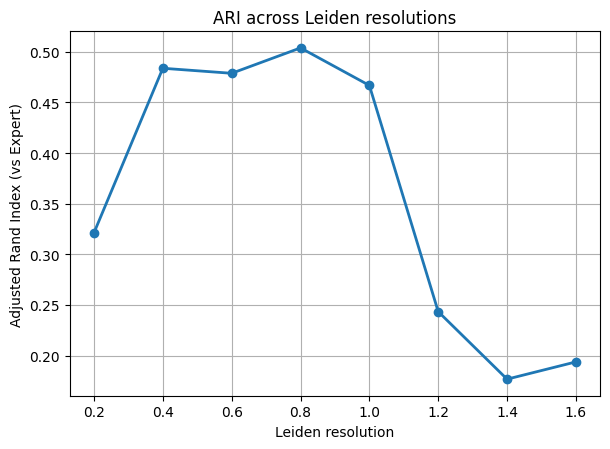

📊 Saved ARI plot: results_Python/figures\Leiden_ARI_vs_Resolution.pdf


In [ ]:
# ======================================================
# Leiden sweep + GPT-style marker prompts 
#    – the GPTCelltype loop –
# ======================================================
import os
import re
import json
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# -----------------------------
# Config
# -----------------------------
output_dir = "results_Python/figures"
os.makedirs(output_dir, exist_ok=True)

# Choose the Leiden resolutions you want to explore
resolutions = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]

# Number of top positive markers per cluster to include in the prompt
TOP_MARKERS_PER_CLUSTER = 25

# Tissue label to include in the prompt header
TISSUE_NAME = "mouse growth plate"

# -----------------------------
# Ensure graph is ready
# -----------------------------
if "neighbors" not in adata.uns:
    if 'X_pca' not in adata.obsm:
        sc.pp.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# -----------------------------
# Helper to clean gene names
# -----------------------------
def strip_version(gene):
    # Remove Ensembl-style trailing version (.1, .2, etc.) if present
    return re.sub(r"\.\d+$", "", str(gene))

# -----------------------------
# Collect everything here
# -----------------------------
gpt_prompts = {}          # { "res0.8": "<prompt string>" , ... }
leiden_keys = []          # keep track of created obs keys
marker_tables = {}        # { key: DataFrame of markers }

# -----------------------------
# PDF with spatial cluster plots across resolutions
# -----------------------------
pdf_path = os.path.join(output_dir, "Leiden_Clusters_resolutions.pdf")
pdf = PdfPages(pdf_path)

for res in resolutions:
    key = f"leiden_{res:.1f}"

    # 1) Leiden at this resolution
    sc.tl.leiden(adata, resolution=res, key_added=key, random_state=123)
    adata.obs[key] = adata.obs[key].astype("category")
    leiden_keys.append(key)

    # 2) Plot spatial clusters for this resolution (one page per res)
    fig = sc.pl.spatial(
        adata,
        color=key,
        img_key="hires",
        size=1.3,
        legend_loc="right margin",
        title=f"Leiden Clusters (resolution = {res:.1f})",
        return_fig=True,
        show=False
    )
    pdf.savefig(fig); plt.close(fig)

    # 3) Differential expression (positive markers only) per cluster
    sc.tl.rank_genes_groups(
        adata,
        groupby=key,
        method="wilcoxon",
        pts=True
    )
    df = sc.get.rank_genes_groups_df(adata, group=None)  # columns: names, scores, logfoldchanges, pvals_adj, group, pts, etc.
    df["names"] = df["names"].map(strip_version)

    # Keep only positive markers (by logFC > 0)
    df = df[df["logfoldchanges"] > 0].copy()

    # Keep top N per cluster by score
    df["rank_within_group"] = df.groupby("group")["scores"].rank(ascending=False, method="first")
    df_top = df[df["rank_within_group"] <= TOP_MARKERS_PER_CLUSTER].copy()

    # Save per-resolution marker table
    marker_tables[key] = df_top
    marker_csv = os.path.join(output_dir, f"Markers_{key}.csv")
    df_top.to_csv(marker_csv, index=False)

    # 4) Build a ChatGPT prompt (GPTCelltype-style) for this resolution
    #    We’ll format: header + per-cluster bullet lists with markers and basic stats
    lines = []
    lines.append(f"You are an expert in spatial transcriptomics and musculoskeletal biology.")
    lines.append(f"Task: infer likely cell types for Leiden clusters from a {TISSUE_NAME} Visium slide.")
    lines.append("Use the marker lists per cluster below. Output a concise mapping: Cluster → Cell type, with 1–2 sentence rationale each.")
    lines.append("")
    lines.append(f"Leiden resolution: {res:.1f}  |  Number of clusters: {adata.obs[key].cat.categories.size}")
    lines.append("General rules:")
    lines.append("- Prefer biologically plausible growth plate / bone lineage names (e.g., resting/proliferative/hypertrophic chondrocytes, osteoblasts, osteoclasts/monocytes, MSCs, fibroblasts/tenocytes, myocytes, endothelial/pericytes, immune subsets).")
    lines.append("- If ambiguous, list top 2 candidates with confidence notes.")
    lines.append("- Avoid over-splitting identical states; combine when markers strongly overlap.")
    lines.append("")
    lines.append("Markers per cluster (top positive markers):")

    # For each cluster, list top markers (names, logFC, detection fraction)
    for clust in sorted(adata.obs[key].cat.categories, key=lambda x: int(x) if str(x).isdigit() else x):
        sub = df_top[df_top["group"] == clust].sort_values("scores", ascending=False)
        # build a compact marker string
        # include up to 25 markers: NAME (logFC=, det=)
        marker_strs = []
        for _, r in sub.iterrows():
            # pts: fraction of cells in group with expression (0..1); sometimes labeled "pct_nz_group"
            det = r.get("pts", np.nan)
            if pd.isna(det):
                marker_strs.append(f"{r['names']} (logFC={r['logfoldchanges']:.2f})")
            else:
                marker_strs.append(f"{r['names']} (logFC={r['logfoldchanges']:.2f}, det={det:.2f})")
        # wrap as bullets
        lines.append(f"\nCluster {clust}:")
        if len(marker_strs) == 0:
            lines.append("- [no positive markers detected]")
        else:
            # join in lines of ~8–10 markers to keep width reasonable
            chunk = []
            for i, s in enumerate(marker_strs, 1):
                chunk.append(s)
                if (i % 10 == 0) or (i == len(marker_strs)):
                    lines.append("- " + "; ".join(chunk))
                    chunk = []

    # Suggest final output format
    lines.append("\nReturn your answer as a JSON array of objects like:")
    lines.append('[{"cluster":"0","cell_type":"Hypertrophic chondrocytes","confidence":"high","rationale":"…"}, …]')

    prompt_text = "\n".join(lines)
    gpt_prompts[f"res{res:.1f}"] = prompt_text

# Close the multi-page cluster PDF
pdf.close()
print(f"📄 Saved spatial cluster PDF: {pdf_path}")

# -----------------------------
# Save prompts for later use
# -----------------------------
prompts_txt = os.path.join(output_dir, "Leiden_GPT_Prompts.txt")
with open(prompts_txt, "w", encoding="utf-8") as f:
    for k in gpt_prompts:
        f.write("\n\n" + "="*70 + f"\nPROMPT for {k}\n" + "="*70 + "\n")
        f.write(gpt_prompts[k] + "\n")
print(f"📝 Saved ChatGPT prompts: {prompts_txt}")

prompts_json = os.path.join(output_dir, "Leiden_GPT_Prompts.json")
with open(prompts_json, "w", encoding="utf-8") as f:
    json.dump(gpt_prompts, f, ensure_ascii=False, indent=2)
print(f"🧾 Saved JSON prompts: {prompts_json}")

# -----------------------------
# If we already have Expert_Annotation and want a quick
# evaluation figure, we can compute ARI across the same resolutions.
# -----------------------------
if "Expert_Annotation" in adata.obs.columns:
    from sklearn.metrics import adjusted_rand_score
    adata.obs["Expert_Annotation"] = adata.obs["Expert_Annotation"].astype(str)
    truth = pd.Categorical(adata.obs["Expert_Annotation"]).codes

    ari_rows = []
    for res in resolutions:
        key = f"leiden_{res:.1f}"
        pred = pd.Categorical(adata.obs[key]).codes
        ari = adjusted_rand_score(truth, pred)
        ari_rows.append({"Resolution": res, "ARI": ari})
    ari_df = pd.DataFrame(ari_rows)

    plt.figure(figsize=(6.2, 4.6))
    plt.plot(ari_df["Resolution"], ari_df["ARI"], marker="o", linewidth=2)
    plt.xlabel("Leiden resolution")
    plt.ylabel("Adjusted Rand Index (vs Expert)")
    plt.title("ARI across Leiden resolutions")
    plt.grid(True)
    plt.tight_layout()
    ari_pdf = os.path.join(output_dir, "Leiden_ARI_vs_Resolution.pdf")
    plt.savefig(ari_pdf, dpi=300)
    plt.show()
    print(f"📊 Saved ARI plot: {ari_pdf}")
